In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.set_option('display.max_columns', 200)

In [2]:
sales = pd.read_csv('train.csv')
sales.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
sales.info()
sales.Product_ID.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


3631

In [4]:
sales.shape

(550068, 12)

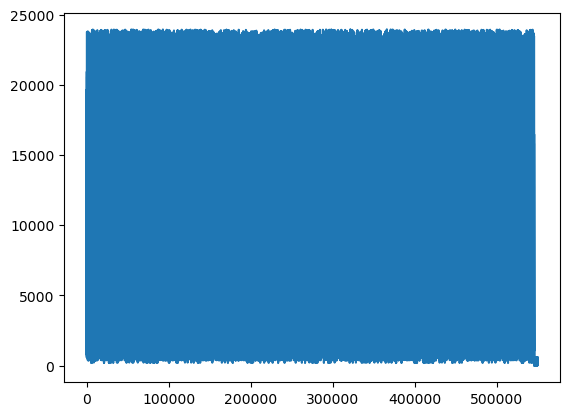

### For training our model we dont need user ID and product ID as these are not features about thhe order. Also these two columns are already defined byb the demographhics such as occupation etc for the user, and product category for the product

In [5]:
def get_age(x):
    match = re.match(r'(-?\d*\.?\d+)', x)
    return match[0]
    # print(splitted)

In [6]:
sales['Age_More_Than'] = sales['Age'].map(get_age)

In [7]:
sales.drop('Age', axis=1, inplace=True)

In [8]:
sales = sales.rename({"Stay_In_Current_City_Years":"Stay_In_Current_City_Years_Atleast"}, axis=1)

In [9]:
sales['Stay_In_Current_City_Years_Atleast'] = sales['Stay_In_Current_City_Years_Atleast'].str.extract(r'(-?\d*\.?\d+)')

In [10]:
sales = sales.astype('object')

In [11]:
# sales[['Age_More_Than', 'Stay_In_Current_City_Years_Atleast']] = pd.to_numeric(sales[['Age_More_Than', 'Stay_In_Current_City_Years_Atleast']])
sales[['Age_More_Than', 'Stay_In_Current_City_Years_Atleast',
       'Purchase']] = sales[['Age_More_Than', 'Stay_In_Current_City_Years_Atleast', 'Purchase']].astype('int64')

In [12]:
sales.Age_More_Than.dtype

dtype('int64')

<Axes: >

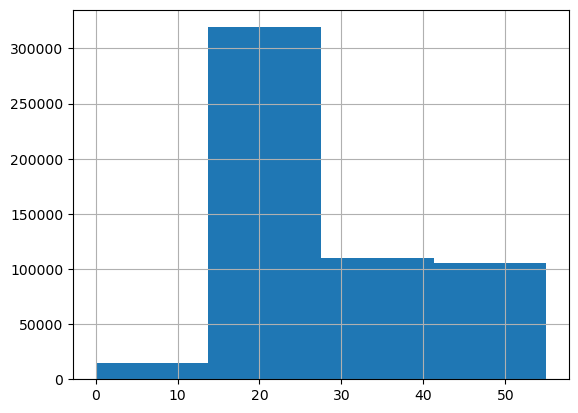

In [13]:
sales['Age_More_Than'].hist(bins=4)

<Axes: >

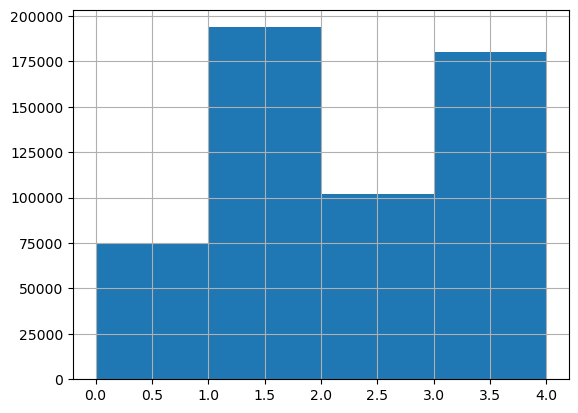

In [14]:
sales['Stay_In_Current_City_Years_Atleast'].hist(bins=4)

In [15]:
sales.drop(['User_ID', 'Product_ID'], axis=1, inplace=True)

In [16]:
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,cross_val_score ,GridSearchCV
from sklearn.metrics import mean_squared_error

In [17]:
X_train, X_test, y_train, y_test = train_test_split(sales,sales['Purchase'],
                test_size=0.2, stratify=sales['Stay_In_Current_City_Years_Atleast'], random_state=42)

In [18]:
for set in (X_train, X_test):
    set.drop('Purchase', axis=1, inplace=True)

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440054 entries, 540805 to 188179
Data columns (total 9 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Gender                              440054 non-null  object
 1   Occupation                          440054 non-null  object
 2   City_Category                       440054 non-null  object
 3   Stay_In_Current_City_Years_Atleast  440054 non-null  int64 
 4   Marital_Status                      440054 non-null  object
 5   Product_Category_1                  440054 non-null  object
 6   Product_Category_2                  301166 non-null  object
 7   Product_Category_3                  133701 non-null  object
 8   Age_More_Than                       440054 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 33.6+ MB


In [20]:
category_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                          OneHotEncoder(sparse_output=False))
numerical_category_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                             OrdinalEncoder(),
                                             StandardScaler()
                                            )

In [21]:
preprocessing = ColumnTransformer([
    ('cat', category_pipeline, make_column_selector(dtype_include=object)),
     ('numerical_cat', numerical_category_pipeline, ['Age_More_Than', 'Stay_In_Current_City_Years_Atleast'])
])

In [22]:
processed = preprocessing.fit_transform(X_train)

In [23]:
processed_df = pd.DataFrame(processed, columns=preprocessing.get_feature_names_out(), index=X_train.index)

In [24]:
processed_df.head()

,cat__Gender_F,cat__Gender_M,cat__Occupation_0,cat__Occupation_1,cat__Occupation_2,cat__Occupation_3,cat__Occupation_4,cat__Occupation_5,cat__Occupation_6,cat__Occupation_7,cat__Occupation_8,cat__Occupation_9,cat__Occupation_10,cat__Occupation_11,cat__Occupation_12,cat__Occupation_13,cat__Occupation_14,cat__Occupation_15,cat__Occupation_16,cat__Occupation_17,cat__Occupation_18,cat__Occupation_19,cat__Occupation_20,cat__City_Category_A,cat__City_Category_B,cat__City_Category_C,cat__Marital_Status_0,cat__Marital_Status_1,cat__Product_Category_1_1,cat__Product_Category_1_2,cat__Product_Category_1_3,cat__Product_Category_1_4,cat__Product_Category_1_5,cat__Product_Category_1_6,cat__Product_Category_1_7,cat__Product_Category_1_8,cat__Product_Category_1_9,cat__Product_Category_1_10,cat__Product_Category_1_11,cat__Product_Category_1_12,cat__Product_Category_1_13,cat__Product_Category_1_14,cat__Product_Category_1_15,cat__Product_Category_1_16,cat__Product_Category_1_17,cat__Product_Category_1_18,cat__Product_Category_1_19,cat__Product_Category_1_20,cat__Product_Category_2_2.0,cat__Product_Category_2_3.0,cat__Product_Category_2_4.0,cat__Product_Category_2_5.0,cat__Product_Category_2_6.0,cat__Product_Category_2_7.0,cat__Product_Category_2_8.0,cat__Product_Category_2_9.0,cat__Product_Category_2_10.0,cat__Product_Category_2_11.0,cat__Product_Category_2_12.0,cat__Product_Category_2_13.0,cat__Product_Category_2_14.0,cat__Product_Category_2_15.0,cat__Product_Category_2_16.0,cat__Product_Category_2_17.0,cat__Product_Category_2_18.0,cat__Product_Category_3_3.0,cat__Product_Category_3_4.0,cat__Product_Category_3_5.0,cat__Product_Category_3_6.0,cat__Product_Category_3_8.0,cat__Product_Category_3_9.0,cat__Product_Category_3_10.0,cat__Product_Category_3_11.0,cat__Product_Category_3_12.0,cat__Product_Category_3_13.0,cat__Product_Category_3_14.0,cat__Product_Category_3_15.0,cat__Product_Category_3_16.0,cat__Product_Category_3_17.0,cat__Product_Category_3_18.0,numerical_cat__Age_More_Than,numerical_cat__Stay_In_Current_City_Years_Atleast
540805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.366792,-0.665730
223233,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.105199,-1.441259
421464,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.110021,0.885329
71164,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.848428,-1.441259
198525,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.366792,1.660859


#### Pipeline Tested

### now choose model

#### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())

In [26]:
tree_reg.fit(X_train, y_train)
predictions_on_train_set = tree_reg.predict(X_train)

In [27]:
rmse = mean_squared_error(y_train, predictions_on_train_set, squared=False)
rmse

2301.318876493435

#### Cross Validate

In [28]:
cv_rmses = cross_val_score(tree_reg, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')

#### root mean squared errors for 10 fold cv

In [29]:
pd.Series(-cv_rmses).describe()

count      10.000000
mean     3289.441946
std        15.970861
min      3269.258082
25%      3275.877079
50%      3288.201644
75%      3302.679590
max      3314.027362
dtype: float64

### Lets try Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
for_reg = make_pipeline(preprocessing, RandomForestRegressor())

In [ ]:
for_reg.fit(X_train, y_train)